<a href="https://colab.research.google.com/github/Strojove-uceni/final-projects-i_am_not_a_robot/blob/main/captcha_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# captcha_model.ipynb

Notebook includes complete solution of the project. 

## Libraries

In [ ]:
# install and load packages
! pip install patool
! pip install pyunpack

import argparse
import os
import random
import requests
import zipfile
import errno
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pyunpack import Archive
import glob
import string
from PIL import Image
from tqdm import tqdm
import torch.nn.functional 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


     |████████████████████████████████| 77 kB 3.2 MB/s 


## Workspace setup

Connecting to Google drive in order to gain access to the data and model-storage folders:

In [ ]:
# connect to google drive for saving models
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Check the GPU:

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_cudas = torch.cuda.device_count()

print(f'We are now using {device}. There are {n_cudas} available gpus.')

if torch.cuda.is_available():
    print(f'{torch.cuda.get_device_name(0)}')

We are now using cuda. There are 1 available gpus.
Tesla K80


## Data preprocessing

### Custom Data

old: 

~~Train data available at: https://drive.google.com/file/d/1AswiYpd_CIab6swI-XA88H_IBj0Dyd3G~~

~~Test data available at: https://drive.google.com/file/d/1AsOV43Wc_ZR_1yMbesvq0uNAlUrqK7_Y~~

new:

Train data available at: https://drive.google.com/file/d/1-78M2Rj7XLy1tQqpyeLsI-ya4gJCEU4d

Test data available at: https://drive.google.com/file/d/1-74h6oEnYm_8uCDrDNvyO2iy_LSSlLsi

## Dimension
(No. files x width x height x channels)

Size of train data: 299 975 x 180 x 60 x 3

Size of test data: 50 000 x 180 x 60 x 3

In [ ]:
# # old
# # download files from google drive

# # load train data
# !gdown --id 1AswiYpd_CIab6swI-XA88H_IBj0Dyd3G
# # load test data
# !gdown --id 1AsOV43Wc_ZR_1yMbesvq0uNAlUrqK7_Y


In [ ]:
# new
# download files from google drive

# load train data
!gdown --id 1-78M2Rj7XLy1tQqpyeLsI-ya4gJCEU4d
# load test data
!gdown --id 1-74h6oEnYm_8uCDrDNvyO2iy_LSSlLsi


Downloading...
From: https://drive.google.com/uc?id=1-78M2Rj7XLy1tQqpyeLsI-ya4gJCEU4d
To: /content/captcha_train.tar.gz
100% 2.82G/2.82G [00:36<00:00, 78.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-74h6oEnYm_8uCDrDNvyO2iy_LSSlLsi
To: /content/captcha_test.tar.gz
100% 470M/470M [00:03<00:00, 135MB/s] 


In [ ]:
# create folders to unzip data
! mkdir 'train'
! mkdir 'test'

In [ ]:
# unzip data
Archive('captcha_train.tar.gz').extractall('train')
Archive('captcha_test.tar.gz').extractall('test')

In [ ]:
# check number of files
train_labels = os.listdir('train/train')
print('train files:', len(train_labels))

test_labels = os.listdir('test/test')
print('test files:', len(test_labels))

train files: 299975
test files: 50000


In [ ]:
captcha_len = 6

### Dataset preprocess

In [ ]:
# check distribution of symbols in train set

# these are all symbols the captchas will have
symbols = string.ascii_uppercase + string.ascii_lowercase + string.digits  

symbols_help = string.ascii_lowercase + string.digits 
index = {}
for cha in symbols_help:
  index[cha] = 0


In [ ]:
for item in train_labels:
  get_label = str(item).split('.')[0]
  for cha in get_label:
    index[cha] += 1

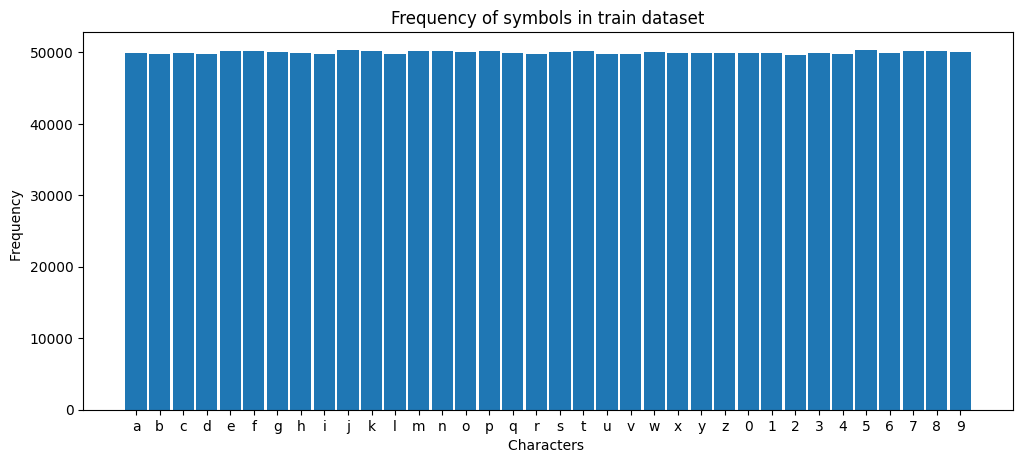

In [ ]:
plt.figure(num=None, figsize=(12, 5), dpi=100, facecolor='w', edgecolor='k')
plt.bar(index.keys(), index.values(), width=0.9)
plt.title('Frequency of symbols in train dataset')
plt.xlabel("Characters ", fontsize=10)  
plt.ylabel("Frequency  ", fontsize=10)
plt.show()

### Create Data Loader

In [ ]:
workers = 2                           # worker threads for loading the data with the DataLoader
batch_size = 256                      # size of batch
image_size = [60, 180]                # size of imput images
nc = 3                                # number of color channels in the input images

# normalization parameters
normalize_mean = (0.485, 0.456, 0.406)
normalize_std = (0.229, 0.224, 0.225)

# for reproducibility
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [ ]:
class Custom_Dataset(torch.utils.data.Dataset):
    
    def __init__(self, data_dir, data_labels):
        self.data_dir = data_dir
        self.data_labels = data_labels
        
    def __len__(self):
        return len(self.data_labels)
    
    def __getitem__(self, index):
        image_label = self.data_labels[index]
        image_fp = os.path.join(self.data_dir, image_label)
        image = Image.open(image_fp).convert('RGB')
        image = self.transform(image)
        text = image_label.split(".")[0]
        return image, text
    
    def transform(self, image):
        
        transform_ops = transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize(normalize_mean, normalize_std),
        ])
        return transform_ops(image)

In [ ]:
# create dataloaders

dataset_train = Custom_Dataset('train/train', train_labels) 
dataset_test = Custom_Dataset('test/test', test_labels)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, num_workers=workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, num_workers=workers, shuffle=False)

print(len(train_loader), len(test_loader))

1172 196


In [ ]:
# check dimensions
print(len(train_labels)/batch_size, len(test_labels)/batch_size)

1171.77734375 195.3125


In [ ]:
# decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def UnNormalizeBatch(batch):
    for i in range(batch.shape[3]):
       batch[:,:,:,i] = (batch[:,:,:,i] * normalize_std[i]) + normalize_mean[i]

    return batch

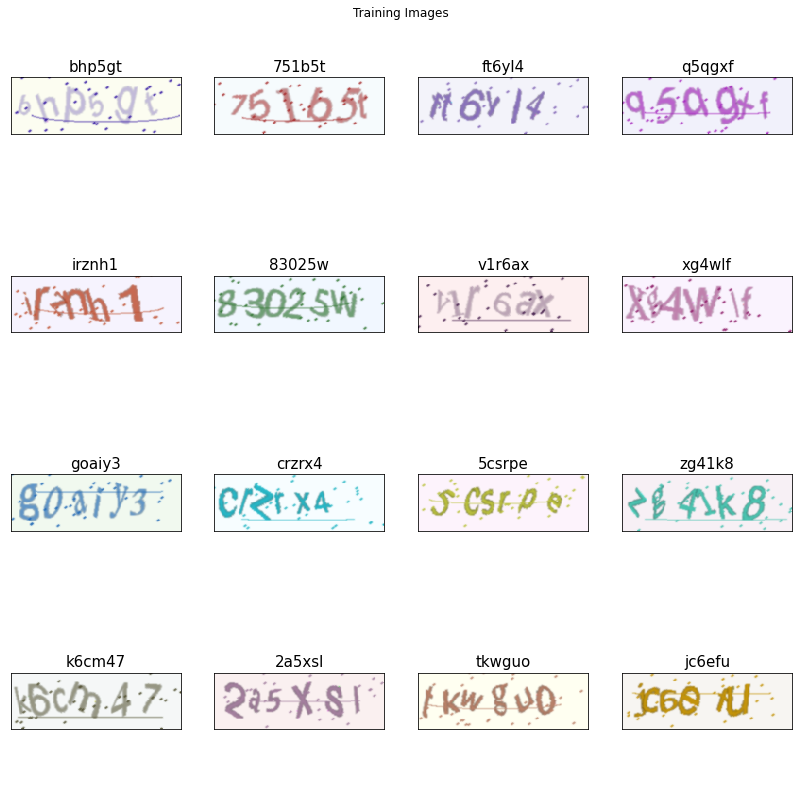

In [ ]:
# view some train images
real_batch = next(iter(train_loader))
real_batch_pictures = np.transpose(real_batch[0].to(device).cpu().detach().numpy(),(0,2,3,1))
real_batch_pictures = UnNormalizeBatch(real_batch_pictures)

fig = plt.figure(figsize=(14,14))
plt.axis("off")
plt.title("Training Images")

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(real_batch_pictures[i], interpolation='nearest')
    plt.title(real_batch[1][i], color='k', fontsize=15)

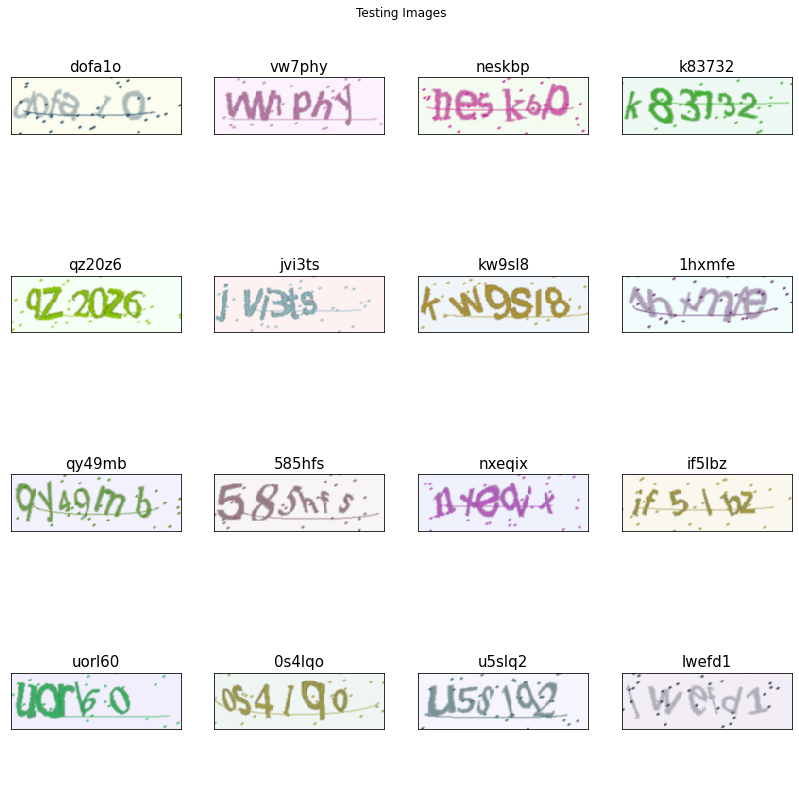

In [ ]:
# view some test images
real_batch = next(iter(test_loader))
real_batch_pictures = np.transpose(real_batch[0].to(device).cpu().detach().numpy(),(0,2,3,1))
real_batch_pictures = UnNormalizeBatch(real_batch_pictures)

fig = plt.figure(figsize=(14,14))
plt.axis("off")
plt.title("Testing Images")

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(real_batch_pictures[i], interpolation='nearest')
    plt.title(real_batch[1][i], color='k', fontsize=15)

## Creating model

In [ ]:
symbols_char = {k:v for k,v in enumerate(symbols, start=0)}
symbols_idx = {v:k for k,v in symbols_char.items()}
num_symbols = len(symbols_idx)

### Define model with resnet 18

In [ ]:
rnn_hidden_size = 256

In [ ]:
resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
class CTC(nn.Module):
    
    def __init__(self, num_symbols, rnn_hidden_size=256, dropout=0.1):
        
        super(CTC, self).__init__()
        self.num_chars = num_symbols
        self.rnn_hidden_size = rnn_hidden_size
        self.dropout = dropout
        
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2 - for resnet18
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3,6), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(1024, 256)

        
        # RNN
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_symbols)
        
    def forward(self, batch):
        
        batch = self.cnn_p1(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])
        
        batch = self.cnn_p2(batch) # [batch_size, channels, height, width]
        # print(batch.size())# torch.Size([-1, 256, 4, 10])
        
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 10, 256, 4])
         
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 10, 1024])
        
        batch = self.linear1(batch)
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 512])
        
        batch = self.linear2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 20])
        
        batch = batch.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
        # print(batch.size()) # torch.Size([10, -1, 20])
        
        return batch

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
ctc = CTC(num_symbols, rnn_hidden_size=rnn_hidden_size)
ctc.apply(weights_init)
ctc = ctc.to(device)

In [ ]:
ctc

CTC(
  (cnn_p1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [ ]:
image_batch, text_batch = iter(train_loader).next()
print(image_batch.size(), text_batch)

torch.Size([256, 3, 60, 180]) ('of2xoe', '46uakj', 'byz4ue', 'metd6i', 'dks7oj', '86n2r0', '23l8rf', 'efculc', '4gsn01', '381tv3', '9z3jc2', 'p1rn93', '946d6s', '4ty6x6', '3oqmxz', 'obr3cw', 'uxwds8', 'wbob3g', 'ehcghb', 'ig107n', 'qthw1q', '7t1hvj', '6kxct9', 'c9305w', 'o4rpr7', 'vahgqg', 'zm5u13', '47sel5', 'q4usn9', '3udjh1', '0cgenr', 'rgrphw', 'akj8ox', 'crb54f', 'qywaya', '658dxk', 'sfyrkj', 'dr2svf', '459kg7', '7tfhvo', 'jtiwaz', '5qbv5j', 'hucfum', '2n8jl2', 'scr16p', 'dt2q9c', 'b4re3e', 'o0cin7', 's5fhdr', 'rz0skp', 'kj56w9', '0nwbpa', 'akgozc', 'gwslng', '4d31oi', 'd13xm5', 'ra5vzj', 'g1pa5m', '0dwqox', 'n75z05', 'auotdy', 'o9hilq', 'i1usu6', 'bcet5n', 'ga8tue', 'cdatwf', 'n3t1h7', '85z32a', 'y2s78g', 'o7gkxp', 'lz26x9', 'stsb34', 'pra9q1', '6d8l1e', 'q3qsl3', '5jgbco', 'j1ij72', '2ltdgp', '9g7xb3', '4qvinw', 'im1czj', '4d1vfp', '4r4fis', '5k10nk', 'n584v9', 'tm34dq', 'bus698', 'jyuy2y', 'l5qkd6', 'fxfi9l', 'z4taw8', 'yhrf0b', 'kzoya5', 'f0e95z', 'qv5nk4', 'ruz0wo', 'n41yuw',

In [ ]:
text_batch_logits = ctc(image_batch.to(device))
print(text_batch)
print(text_batch_logits.shape)

('of2xoe', '46uakj', 'byz4ue', 'metd6i', 'dks7oj', '86n2r0', '23l8rf', 'efculc', '4gsn01', '381tv3', '9z3jc2', 'p1rn93', '946d6s', '4ty6x6', '3oqmxz', 'obr3cw', 'uxwds8', 'wbob3g', 'ehcghb', 'ig107n', 'qthw1q', '7t1hvj', '6kxct9', 'c9305w', 'o4rpr7', 'vahgqg', 'zm5u13', '47sel5', 'q4usn9', '3udjh1', '0cgenr', 'rgrphw', 'akj8ox', 'crb54f', 'qywaya', '658dxk', 'sfyrkj', 'dr2svf', '459kg7', '7tfhvo', 'jtiwaz', '5qbv5j', 'hucfum', '2n8jl2', 'scr16p', 'dt2q9c', 'b4re3e', 'o0cin7', 's5fhdr', 'rz0skp', 'kj56w9', '0nwbpa', 'akgozc', 'gwslng', '4d31oi', 'd13xm5', 'ra5vzj', 'g1pa5m', '0dwqox', 'n75z05', 'auotdy', 'o9hilq', 'i1usu6', 'bcet5n', 'ga8tue', 'cdatwf', 'n3t1h7', '85z32a', 'y2s78g', 'o7gkxp', 'lz26x9', 'stsb34', 'pra9q1', '6d8l1e', 'q3qsl3', '5jgbco', 'j1ij72', '2ltdgp', '9g7xb3', '4qvinw', 'im1czj', '4d1vfp', '4r4fis', '5k10nk', 'n584v9', 'tm34dq', 'bus698', 'jyuy2y', 'l5qkd6', 'fxfi9l', 'z4taw8', 'yhrf0b', 'kzoya5', 'f0e95z', 'qv5nk4', 'ruz0wo', 'n41yuw', 'rs73y4', 'kwrsx9', 'v25at1',

### Define model with resnet 152
Slow and doesnt work

In [ ]:
rnn_hidden_size = 128

In [ ]:
resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
class CTC(nn.Module):
    
    def __init__(self, num_symbols, rnn_hidden_size=256, dropout=0.1):
        
        super(CTC, self).__init__()
        self.num_chars = num_symbols
        self.rnn_hidden_size = rnn_hidden_size
        self.dropout = dropout
        
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2 - for resnet18
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(1024, 256, kernel_size=(3,6), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(1024, 128)

        
        # RNN
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_symbols)
        
    def forward(self, batch):
        
        batch = self.cnn_p1(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])
        
        batch = self.cnn_p2(batch) # [batch_size, channels, height, width]
        # print(batch.size())# torch.Size([-1, 256, 4, 10])
        
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 10, 256, 4])
         
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 10, 1024])
        
        batch = self.linear1(batch)
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 512])
        
        batch = self.linear2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 20])
        
        batch = batch.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
        # print(batch.size()) # torch.Size([10, -1, 20])
        
        return batch

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
ctc = CTC(num_symbols, rnn_hidden_size=rnn_hidden_size)
ctc.apply(weights_init)
ctc = ctc.to(device)

In [ ]:
image_batch, text_batch = iter(train_loader).next()
print(image_batch.size(), text_batch)

torch.Size([64, 3, 60, 180]) ('EE1UVV', 'dMAnHP', 'SgCy88', 'sx2yIp', 's3ebSk', 'zaptzs', '5g4MjI', 'FrbONX', '3tntvG', 'u4Ga5Y', 'O8vbh3', 'SYim78', 'xrgUll', '2WSxnx', 'V6pfVn', 'S4QlR1', 'kDaupA', 'NO7aUR', 'hrIrSb', 'ejxDNt', 'BlPlCA', 'j9sWJo', 'beAfhS', 'Fq94Qs', 'cqjV2a', 'Xaux09', 'T4Q12O', 'T9quKc', 'l2rt8s', 'gfyqwR', '0qXWXB', 'MnwhZx', '5MDUWa', 'zr0amW', 'BFYmJ0', '9Zql7k', 'tYhqEM', '4bEJ39', 'z3bpiZ', '6wW7sn', 'WGHn1y', 'NF6pft', 'FAkZQE', 'JAbvKz', '5Gj9aE', 'lXIAJs', 'qbOwEh', 'A78qQM', 'I6w6K8', '7uayXj', '3r6ffh', 'xD16k2', 'vgBkpl', 'YoNAkw', 'OxqGAt', 'CGFHX1', '2EtQbm', 'N7cKEU', 'x3Jlgd', 'BpHA4N', 'NRH7O4', 'paqnaS', '6r5Tj1', 'inmhsr')


In [ ]:
text_batch_logits = ctc(image_batch.to(device))
print(text_batch)
print(text_batch_logits.shape)

### Define model with resnet 101
Slow and doesnt work

In [ ]:
rnn_hidden_size = 256

In [ ]:
resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [ ]:
class CTC(nn.Module):
    
    def __init__(self, num_symbols, rnn_hidden_size=256, dropout=0.1):
        
        super(CTC, self).__init__()
        self.num_chars = num_symbols
        self.rnn_hidden_size = rnn_hidden_size
        self.dropout = dropout
        
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-1]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2 - for resnet101
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(512, 256)

        
        # RNN
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_symbols)
        
    def forward(self, batch):
        
        batch = self.cnn_p1(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])
        
        batch = self.cnn_p2(batch) # [batch_size, channels, height, width]
        # print(batch.size())# torch.Size([-1, 256, 4, 10])
        
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 10, 256, 4])
         
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 10, 1024])
        
        batch = self.linear1(batch)
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 512])
        
        batch = self.linear2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 20])
        
        batch = batch.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
        # print(batch.size()) # torch.Size([10, -1, 20])
        
        return batch

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
ctc = CTC(num_symbols, rnn_hidden_size=rnn_hidden_size)
ctc.apply(weights_init)
ctc = ctc.to(device)

In [ ]:
image_batch, text_batch = iter(train_loader).next()
print(image_batch.size(), text_batch)

torch.Size([128, 3, 60, 180]) ('Mev2Hw', 'PZnJIx', 'LH0AHP', 'Y8vuJR', 'AeWJL1', 'phu1Og', 'bUW0zD', 'PSZkRW', 'kyFxnA', 'PTQ5D4', '7pLBm8', 'K6TTpY', '2GCcSg', '4LPJ6X', 'xPQ4Ju', 'Nra5Ft', 'nuKFYX', 'B8UU37', '7lzX4V', '0ybWrr', '0f9TYZ', 'iy8Xeb', 'Hm2hlt', 'h5Uor7', 'USxaG8', 'IFMARV', 'dmmlGp', 'JutCyh', 'Rd7Uj2', 'ess9Ya', 'IkJgvV', 'Fr5w3I', '0jaxdR', 'eXiiWi', 'mvXz37', '6gir2h', 'B4k6PM', '2YD4kq', 'MgnAuu', 'f6H3YZ', 'mAcNZd', 'MIxDG3', '2GfL1J', 'CNTxnS', 'CSPajS', '4L3O4l', 'EaLN42', 'qNFtbZ', 'l4Leow', 'GPjv4P', 'Hfbk7b', 'zYlZPj', '550287', 'GGBmqZ', 'dAtluX', 'VlHanl', 'vz9gIK', 'ENIRZQ', 'LDSUUs', 'RzUbEc', 'L4KCQH', '5yky9F', 'yAu7hh', 'agkvQB', 'aPCrlP', 'c50R6M', 'ifiFUB', 'DePCIE', 'vQpQMP', 'nK8bax', 't7t7uu', 'iATFov', 'pevVLZ', 'ohwMcJ', 'w7UwX8', 'so4O8e', '0L0o08', 'PUQRMr', 'PbB1OC', 'R5kect', 'Ks9aKz', 'wrC6Bb', 'Hceqo4', 'IBgdog', 'oU9LOq', 'r1bLVv', 'm8BWbN', 'k6BErq', 'jnwksu', '1KyVoh', 'mZV0VQ', '3aW2pN', 'nWfhuF', 'jDy3ba', 'LLtr3U', 'is3T6D', '3zU27N',

In [ ]:
text_batch_logits = ctc(image_batch.to(device))
print(text_batch)
print(text_batch_logits.shape)

('Mev2Hw', 'PZnJIx', 'LH0AHP', 'Y8vuJR', 'AeWJL1', 'phu1Og', 'bUW0zD', 'PSZkRW', 'kyFxnA', 'PTQ5D4', '7pLBm8', 'K6TTpY', '2GCcSg', '4LPJ6X', 'xPQ4Ju', 'Nra5Ft', 'nuKFYX', 'B8UU37', '7lzX4V', '0ybWrr', '0f9TYZ', 'iy8Xeb', 'Hm2hlt', 'h5Uor7', 'USxaG8', 'IFMARV', 'dmmlGp', 'JutCyh', 'Rd7Uj2', 'ess9Ya', 'IkJgvV', 'Fr5w3I', '0jaxdR', 'eXiiWi', 'mvXz37', '6gir2h', 'B4k6PM', '2YD4kq', 'MgnAuu', 'f6H3YZ', 'mAcNZd', 'MIxDG3', '2GfL1J', 'CNTxnS', 'CSPajS', '4L3O4l', 'EaLN42', 'qNFtbZ', 'l4Leow', 'GPjv4P', 'Hfbk7b', 'zYlZPj', '550287', 'GGBmqZ', 'dAtluX', 'VlHanl', 'vz9gIK', 'ENIRZQ', 'LDSUUs', 'RzUbEc', 'L4KCQH', '5yky9F', 'yAu7hh', 'agkvQB', 'aPCrlP', 'c50R6M', 'ifiFUB', 'DePCIE', 'vQpQMP', 'nK8bax', 't7t7uu', 'iATFov', 'pevVLZ', 'ohwMcJ', 'w7UwX8', 'so4O8e', '0L0o08', 'PUQRMr', 'PbB1OC', 'R5kect', 'Ks9aKz', 'wrC6Bb', 'Hceqo4', 'IBgdog', 'oU9LOq', 'r1bLVv', 'm8BWbN', 'k6BErq', 'jnwksu', '1KyVoh', 'mZV0VQ', '3aW2pN', 'nWfhuF', 'jDy3ba', 'LLtr3U', 'is3T6D', '3zU27N', 'vSKvPL', '7eldvz', '5UQCZF',

### Define loss

[Connectionist Temporal Classification (CTC) loss](https://towardsdatascience.com/intuitively-understanding-connectionist-temporal-classification-3797e43a86c)


In [ ]:
criterion = nn.CTCLoss(blank=0)

In [ ]:
def encode_text_batch(text_batch):
    
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
    
    text_batch_concat = "".join(text_batch)
    text_batch_targets = [symbols_idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)
    
    return text_batch_targets, text_batch_targets_lens

In [ ]:
def compute_loss(text_batch, text_batch_logits):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    text_batch_logps = torch.nn.functional.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]  
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), 
                                       dtype=torch.int32).to(device) # [batch_size] 
    #print(text_batch_logps.shape)
    #print(text_batch_logps_lens) 
    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    #print(text_batch_targets)
    #print(text_batch_targets_lens)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

In [ ]:
text_batch_logits.shape

torch.Size([9, 256, 62])

In [ ]:
compute_loss(text_batch, text_batch_logits)

tensor(5.1657, device='cuda:0', grad_fn=<MeanBackward0>)

### Train model

In [ ]:
num_epochs = 8
lr = 0.001
weight_decay = 1e-3
clip_norm = 5

In [ ]:
optimizer = optim.Adam(ctc.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=5)

In [ ]:
ctc = CTC(num_symbols, rnn_hidden_size=rnn_hidden_size)
ctc.apply(weights_init)
ctc = ctc.to(device)

In [ ]:
epoch_losses = []
iteration_losses = []
num_updates_epochs = []

help_const = 0

for epoch in tqdm(range(1, num_epochs+1)):
    epoch_loss_list = [] 
    num_updates_epoch = 0
    for image_batch, text_batch in train_loader:
        optimizer.zero_grad()
        text_batch_logits = ctc(image_batch.to(device))
        loss = compute_loss(text_batch, text_batch_logits)
        iteration_loss = loss.item()

        if np.isnan(iteration_loss) or np.isinf(iteration_loss):
            continue
          
        num_updates_epoch += 1
        iteration_losses.append(iteration_loss)
        epoch_loss_list.append(iteration_loss)
        loss.backward()
        nn.utils.clip_grad_norm_(ctc.parameters(), clip_norm)
        optimizer.step()

        help_const = help_const + 1
        if (help_const % 100 == 0):
            print("Batch:{}    Loss:{}".format(help_const, np.mean(epoch_loss_list)))

    epoch_loss = np.mean(epoch_loss_list)
    print("Epoch:{}    Loss:{}    NumUpdates:{}".format(epoch, epoch_loss, num_updates_epoch))
    epoch_losses.append(epoch_loss)
    num_updates_epochs.append(num_updates_epoch)
    lr_scheduler.step(epoch_loss)

    help_const = 0

  0%|          | 0/8 [00:00<?, ?it/s]

Batch:100    Loss:3.8608634161949156
Batch:200    Loss:3.2783368968963624
Batch:300    Loss:2.913451859156291
Batch:400    Loss:2.6954939365386963
Batch:500    Loss:2.5499842331409455
Batch:600    Loss:2.4453964499632517
Batch:700    Loss:2.3663169835294995
Batch:800    Loss:2.303670770227909
Batch:900    Loss:2.2529990866449143
Batch:1000    Loss:2.210973993420601
Batch:1100    Loss:2.174860110608014


 12%|█▎        | 1/8 [14:19<1:40:17, 859.67s/it]

Epoch:1    Loss:2.151928554826222    NumUpdates:1172
Batch:100    Loss:1.7929505693912506
Batch:200    Loss:1.7888268506526948
Batch:300    Loss:1.785373290379842
Batch:400    Loss:1.7816640162467956
Batch:500    Loss:1.7781522607803344
Batch:600    Loss:1.774710469643275
Batch:700    Loss:1.7715270486899786
Batch:800    Loss:1.7686192166805268
Batch:900    Loss:1.7664706885814667
Batch:1000    Loss:1.7644580792188644
Batch:1100    Loss:1.7620225968144156


 25%|██▌       | 2/8 [28:39<1:25:59, 859.97s/it]

Epoch:2    Loss:1.7605058416571633    NumUpdates:1172
Batch:100    Loss:1.7312841856479644
Batch:200    Loss:1.7303621685504913
Batch:300    Loss:1.7309559432665507
Batch:400    Loss:1.730119313299656
Batch:500    Loss:1.7285985794067382
Batch:600    Loss:1.7282406864563624
Batch:700    Loss:1.7274006588118418
Batch:800    Loss:1.726480687558651
Batch:900    Loss:1.7258671685059865
Batch:1000    Loss:1.7250421252250672
Batch:1100    Loss:1.7250000289353458


 38%|███▊      | 3/8 [42:59<1:11:40, 860.05s/it]

Epoch:3    Loss:1.7247610883501203    NumUpdates:1172
Batch:100    Loss:1.713146299123764
Batch:200    Loss:1.7142563027143478
Batch:300    Loss:1.7133514821529388
Batch:400    Loss:1.7123890224099159
Batch:500    Loss:1.71237810254097
Batch:600    Loss:1.7123039994637173
Batch:700    Loss:1.7124360842364175
Batch:800    Loss:1.7122382037341595
Batch:900    Loss:1.7118245795038012
Batch:1000    Loss:1.7116973997354508
Batch:1100    Loss:1.7113403650847347


 50%|█████     | 4/8 [57:22<57:23, 860.94s/it]  

Epoch:4    Loss:1.71127485171113    NumUpdates:1172
Batch:100    Loss:1.7073088693618774
Batch:200    Loss:1.7048203802108766
Batch:300    Loss:1.7050622936089834
Batch:400    Loss:1.704994952082634
Batch:500    Loss:1.7057991993427277
Batch:600    Loss:1.7059071199099223
Batch:700    Loss:1.7053621319362096
Batch:800    Loss:1.7055574341118336
Batch:900    Loss:1.7051145753595565
Batch:1000    Loss:1.7050440930128097
Batch:1100    Loss:1.704734025001526


 62%|██████▎   | 5/8 [1:11:43<43:03, 861.03s/it]

Epoch:5    Loss:1.7047127993847322    NumUpdates:1172
Batch:100    Loss:1.6995819580554963
Batch:200    Loss:1.7011866652965546
Batch:300    Loss:1.701724705696106
Batch:400    Loss:1.701735437810421
Batch:500    Loss:1.7002942130565644
Batch:600    Loss:1.7003369561831156
Batch:700    Loss:1.7000065573624201
Batch:800    Loss:1.6999251553416252
Batch:900    Loss:1.6999946081638335
Batch:1000    Loss:1.700039757490158
Batch:1100    Loss:1.699685150493275


 75%|███████▌  | 6/8 [1:26:03<28:41, 860.71s/it]

Epoch:6    Loss:1.699383342937398    NumUpdates:1172
Batch:100    Loss:1.6952188050746917
Batch:200    Loss:1.6964336109161378
Batch:300    Loss:1.6967614531517028
Batch:400    Loss:1.6954344764351845
Batch:500    Loss:1.6966336047649384
Batch:600    Loss:1.6971405760447185
Batch:700    Loss:1.697492106471743
Batch:800    Loss:1.697349644601345
Batch:900    Loss:1.6973100504610275
Batch:1000    Loss:1.697435621380806
Batch:1100    Loss:1.6971598843010989


 88%|████████▊ | 7/8 [1:40:20<14:19, 859.36s/it]

Epoch:7    Loss:1.697042330031509    NumUpdates:1172
Batch:100    Loss:1.6960063076019287
Batch:200    Loss:1.6960333859920502
Batch:300    Loss:1.6958999967575072
Batch:400    Loss:1.6959276241064072
Batch:500    Loss:1.6967576985359192
Batch:600    Loss:1.697258517742157
Batch:700    Loss:1.697140349660601
Batch:800    Loss:1.696830354332924
Batch:900    Loss:1.6965246605873108
Batch:1000    Loss:1.6962000048160553
Batch:1100    Loss:1.696282936551354


100%|██████████| 8/8 [1:54:35<00:00, 859.43s/it]

Epoch:8    Loss:1.6963046141248515    NumUpdates:1172


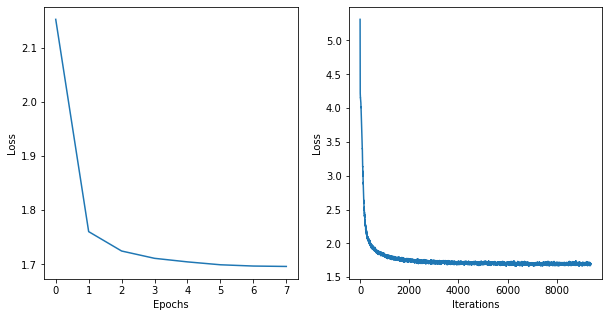

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epoch_losses)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(iteration_losses)
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Loss")

plt.show()

## Save model

In [ ]:
PATH = "/content/drive/MyDrive/Colab Notebooks/01SU2/CAPTCHA/model_new_resnet18_5.pt"
torch.save(ctc.state_dict(), PATH)

## Load model

In [ ]:
PATH = "/content/drive/MyDrive/Colab Notebooks/01SU2/CAPTCHA/model_new_resnet18_5.pt"

ctc = CTC(num_symbols, rnn_hidden_size=rnn_hidden_size)
ctc.apply(weights_init)
ctc = ctc.to(device)

ctc.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## Make predictions

In [ ]:
def decode_predictions(text_batch_logits):

    text_batch_tokens = torch.nn.functional.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [symbols_char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

In [ ]:
results_train = pd.DataFrame(columns=['actual', 'prediction'])
# train_loader = DataLoader(trainset, batch_size=16, num_workers=1, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(train_loader, leave=True):
        text_batch_logits = ctc(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_train = pd.concat([results_train, df])
results_train = results_train.reset_index(drop=True)

100%|██████████| 1172/1172 [08:42<00:00,  2.24it/s]


In [ ]:
results_test = pd.DataFrame(columns=['actual', 'prediction'])
# test_loader = DataLoader(testset, batch_size=16, num_workers=1, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(test_loader, leave=True):
        text_batch_logits = ctc(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_test = pd.concat([results_test, df])
results_test = results_test.reset_index(drop=True)

100%|██████████| 196/196 [01:22<00:00,  2.38it/s]


In [ ]:
print(results_train.shape)
results_train.head()

(299975, 2)


,actual,prediction
0,tw8mj1,ttww8mmj1
1,tedr8r,teedrrrrr
2,p1pnoh,pppppnohh
3,7i29o6,77i299o66
4,fjtfwt,fjjtfwwtt


In [ ]:
print(results_test.shape)
results_test.head()

(50000, 2)


,actual,prediction
0,dofa1o,d0faa11oo
1,vw7phy,vww77phhy
2,neskbp,neeeskbbp
3,k83732,k88333322
4,qz20z6,qqzz20zz6


In [ ]:
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [ ]:
results_train['prediction_corrected'] = results_train['prediction'].apply(correct_prediction)
results_train.head()

,actual,prediction,prediction_corrected
0,tw8mj1,ttww8mmj1,tw8mj1
1,tedr8r,teedrrrrr,tedr
2,p1pnoh,pppppnohh,pnoh
3,7i29o6,77i299o66,7i29o6
4,fjtfwt,fjjtfwwtt,fjtfwt


In [ ]:
results_test['prediction_corrected'] = results_test['prediction'].apply(correct_prediction)
results_test.head()

,actual,prediction,prediction_corrected
0,dofa1o,d0faa11oo,d0fa1o
1,vw7phy,vww77phhy,vw7phy
2,neskbp,neeeskbbp,neskbp
3,k83732,k88333322,k832
4,qz20z6,qqzz20zz6,qz20z6


# Evaluate model

In [ ]:
mistakes_df = results_test[results_test['actual'] != results_test['prediction_corrected']]
mistakes_df

,actual,prediction,prediction_corrected
0,dofa1o,d0faa11oo,d0fa1o
3,k83732,k88333322,k832
9,585hfs,55555hhfs,5hfs
19,xoplwo,xopppwwwo,xopwo
21,p4vp8c,pppppp8cc,p8c
...,...,...,...
49929,pgh4d2,ppgjj4dd2,pgj4d2
49963,pdf9r5,ppdd99rr5,pd9r5
49966,79ow6o,7799oww66,79ow6
49993,wg1ako,wwg11akkc,wg1akc


In [ ]:
results_test

,actual,prediction,prediction_corrected
0,dofa1o,d0faa11oo,d0fa1o
1,vw7phy,vww77phhy,vw7phy
2,neskbp,neeeskbbp,neskbp
3,k83732,k88333322,k832
4,qz20z6,qqzz20zz6,qz20z6
...,...,...,...
49995,2x67p4,2xx677pp4,2x67p4
49996,fi4fdt,fii44fddt,fi4fdt
49997,94uy7r,9944uyy7r,94uy7r
49998,ndq6fr,nddqq66fr,ndq6fr


In [ ]:
print(mistakes_df['prediction_corrected'].str.len().value_counts())

5    6316
4    2535
6    1368
3     281
2      40
7      29
1       1
Name: prediction_corrected, dtype: int64


In [ ]:
mask = mistakes_df['prediction_corrected'].str.len() == captcha_len
mistakes_df[mask]

,actual,prediction,prediction_corrected
0,dofa1o,d0faa11oo,d0fa1o
47,od5trk,oddd6trrk,od6trk
81,mxe1vg,mmxxervvg,mxervg
198,zx1mxk,zxxlmmxxk,zxlmxk
221,5dskvk,5dddfkvvk,5dfkvk
...,...,...,...
49732,lnyrhc,jnyrhhccc,jnyrhc
49810,4f1jmi,4ff1jmmjj,4f1jmj
49925,2i1qt2,2j11qt222,2j1qt2
49929,pgh4d2,ppgjj4dd2,pgj4d2


In [ ]:
train_accuracy = accuracy_score(results_train['actual'], results_train['prediction_corrected'])
print('Train accuracy: ', train_accuracy)
test_accuracy = accuracy_score(results_test['actual'], results_test['prediction_corrected'])
print('Test accuracy: ', test_accuracy)

Train accuracy:  0.796439703308609
Test accuracy:  0.7886


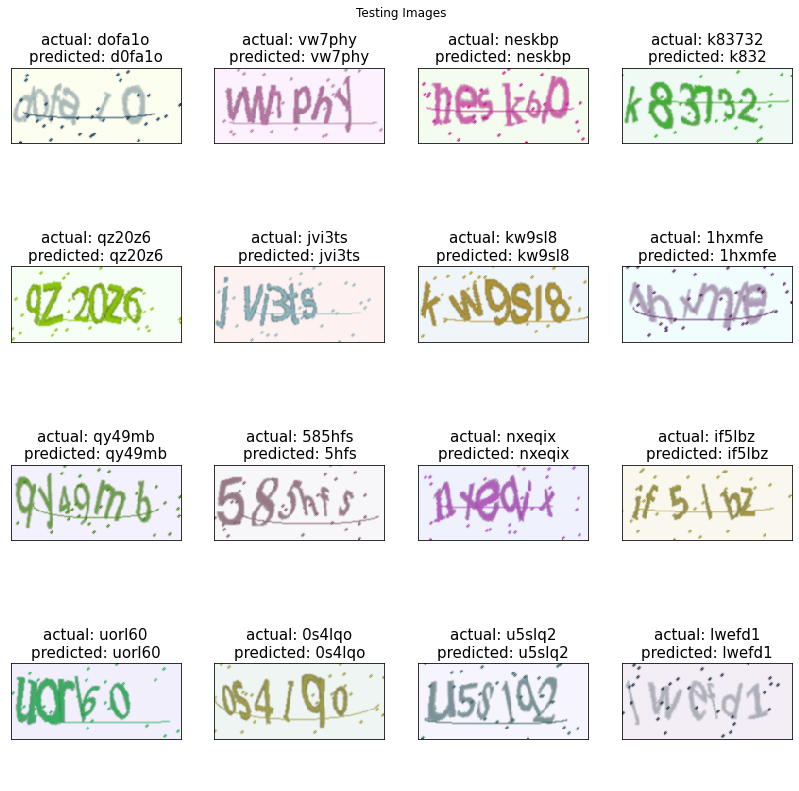

In [ ]:
# view some test images and predictions

fig = plt.figure(figsize=(14,14))
plt.axis("off")
plt.title("Testing Images")

for i in range(16):
    result = results_test.iloc[i]
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    img = mpimg.imread('test/test/{}.png'.format(result[0]))
    ax.imshow(img, interpolation='nearest')
    plt.title('actual: ' + result[0] + '\n' + 'predicted: ' + result[2], color='k', fontsize=15)

## Distance for the comparison of strings similarity
[Ratcliff-Obershelp similarity
](https://itnext.io/string-similarity-the-basic-know-your-algorithms-guide-3de3d7346227)

In [ ]:
! pip install textdistance

from textdistance import ratcliff_obershelp

In [ ]:
for i in tqdm(range(len(results_train))):
    results_train['ratcliff_obershelp'] = ratcliff_obershelp(results_train.iloc[i,0], results_train.iloc[i,2])

100%|██████████| 299975/299975 [04:42<00:00, 1060.33it/s]


In [ ]:
for i in tqdm(range(len(results_test))):
    results_test['ratcliff_obershelp'] = ratcliff_obershelp(results_test.iloc[i,0], results_test.iloc[i,2])

100%|██████████| 50000/50000 [00:19<00:00, 2510.94it/s]


In [ ]:
print('Train Ratcliff-Obershelp: ', results_train['ratcliff_obershelp'].mean())
print('Test Ratcliff-Obershelp: ', results_test['ratcliff_obershelp'].mean())

Train Ratcliff-Obershelp:  1.0
Test Ratcliff-Obershelp:  0.9090909090903921
